### Configuración de librerias

> ##### Instalación e importación de librerias

In [52]:
# Paquetes requeridos
# pandas, numpy, matplotlib, scikit-learn y statsmodels

# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Codificación de variables categóricas
from sklearn.preprocessing import LabelEncoder

# Transformación de variables numéricas
from scipy.stats import skew

# Escalado de características
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


### 1. Cargar y preparar datos

> ##### a. Cargar el dataset y visualizar las primeras filas

In [2]:
# Cargar el dataset
paso1a_raw_data_stores_sales = pd.read_csv('../data/raw/stores_sales_forecasting_updated_v3.1.csv', 
                 sep=';',
                 encoding='utf-8')

# Inspección visual
paso1a_raw_data_stores_sales.columns.tolist()
# o también
list(paso1a_raw_data_stores_sales.columns)

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Branch',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Discount',
 'Profit']

In [3]:
paso1a_raw_data_stores_sales.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,849,CA-2017-107503,1/01/2017,6/01/2017,Standard Class,GA-14725,Guy Armstrong,Consumer,United States,Lorain,...,44052,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",48.896,4,0.2,8.5568
1,4010,CA-2017-144463,1/01/2017,5/01/2017,Standard Class,SC-20725,Steven Cartwright,Consumer,United States,Los Angeles,...,90036,West,FUR-FU-10001215,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Brentwood Wall ...",474.430,11,0.0,199.2606
2,8071,CA-2017-151750,1/01/2017,5/01/2017,Standard Class,JM-15250,Janet Martin,Consumer,United States,Huntsville,...,77340,Central,FUR-FU-10002116,Furniture,Furnishings,"Tenex Carpeted, Granite-Look or Clear Contempo...",141.420,5,0.6,-187.3815
3,8072,CA-2017-151750,1/01/2017,5/01/2017,Standard Class,JM-15250,Janet Martin,Consumer,United States,Huntsville,...,77340,Central,FUR-CH-10003199,Furniture,Chairs,Office Star - Contemporary Task Swivel Chair,310.744,4,0.3,-26.6352
4,867,CA-2014-149020,10/01/2014,15/01/2014,Standard Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,...,22153,South,FUR-FU-10000965,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,1,0.0,21.2954


In [4]:
# Analisis de variables disponibles y valores nulos
print("=== VARIABLES DISPONIBLES ===")
columnas_info = pd.DataFrame({
    'Variable': paso1a_raw_data_stores_sales.columns,
    'Tipo': paso1a_raw_data_stores_sales.dtypes.values,
    'Nulos': paso1a_raw_data_stores_sales.isnull().sum().values
})
print(columnas_info.to_string(index=False))


=== VARIABLES DISPONIBLES ===
     Variable    Tipo  Nulos
       Row ID   int64      0
     Order ID  object      0
   Order Date  object      0
    Ship Date  object      0
    Ship Mode  object      0
  Customer ID  object      0
Customer Name  object      0
      Segment  object      0
      Country  object      0
         City  object      0
        State  object      0
       Branch  object      0
  Postal Code   int64      0
       Region  object      0
   Product ID  object      0
     Category  object      0
 Sub-Category  object      0
 Product Name  object      0
        Sales float64      0
     Quantity   int64      0
     Discount float64      0
       Profit float64      0


> ##### b. Hallazgos del EDA (Fase 2)

In [5]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso1b_preparacion_data_stores_sales = paso1a_raw_data_stores_sales.copy()

In [6]:
# Convertir columnas de fecha a datetime
paso1b_preparacion_data_stores_sales['Order Date'] = pd.to_datetime(paso1b_preparacion_data_stores_sales['Order Date'], format='%d/%m/%Y')
paso1b_preparacion_data_stores_sales['Ship Date'] = pd.to_datetime(paso1b_preparacion_data_stores_sales['Ship Date'], format='%d/%m/%Y')

# Ordenar por fecha
paso1b_preparacion_data_stores_sales = paso1b_preparacion_data_stores_sales.sort_values('Order Date').reset_index(drop=True)

# Verificar tipos de datos
print(paso1b_preparacion_data_stores_sales.dtypes)

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Branch                   object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object


> ##### c. Determinar los lags más adecuados para modelos de forecasting

In [7]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso1c_lags_data_stores_sales = paso1b_preparacion_data_stores_sales.copy()

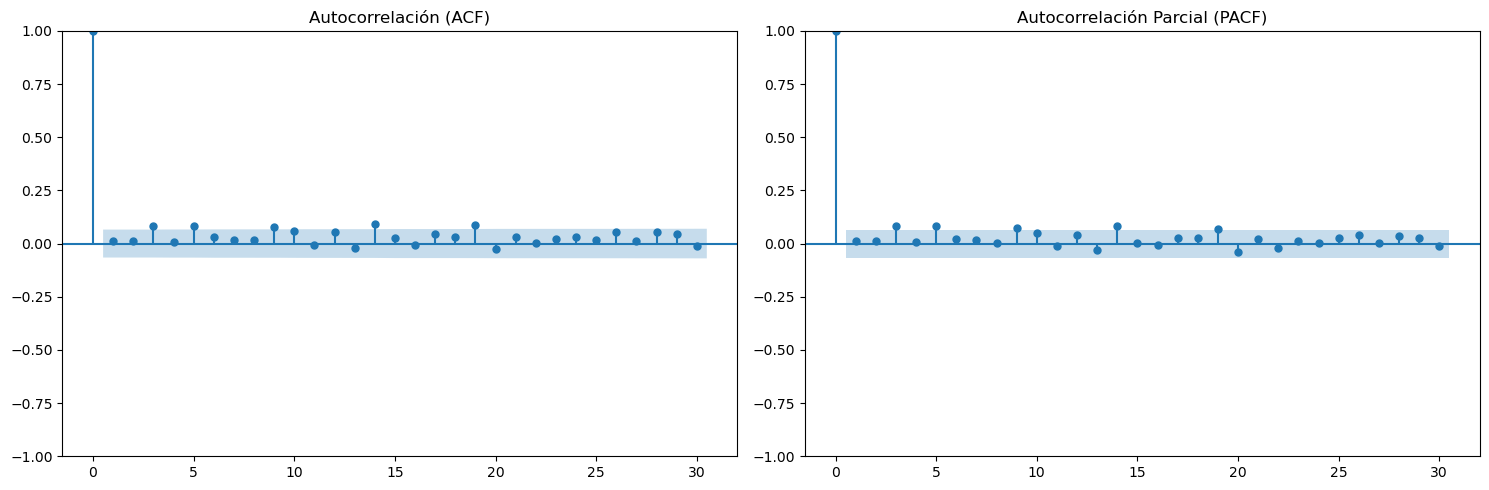

In [8]:
# Crear serie temporal agregada por fecha para análisis de lags
df_daily = paso1c_lags_data_stores_sales.groupby('Order Date')['Sales'].sum().reset_index()

# Calcular autocorrelación para diferentes lags
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF
plot_acf(df_daily['Sales'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelación (ACF)')

# PACF
plot_pacf(df_daily['Sales'], lags=30, ax=axes[1])
axes[1].set_title('Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

In [9]:
# Crear features de lags basados en el análisis

lags_to_create = [1, 7, 14, 30]

print(f"Lags seleccionados para el modelo: {lags_to_create}")
print("Estos lags serán utilizados como features en el modelo de forecasting")

Lags seleccionados para el modelo: [1, 7, 14, 30]
Estos lags serán utilizados como features en el modelo de forecasting


### 2 Aplicación de procesos de Ingeniería de Características

In [24]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso2_ingenieria_data_stores_sales = paso1c_lags_data_stores_sales.copy()

In [25]:
# Mostrar información inicial
print("Variables numéricas:")
print(paso2_ingenieria_data_stores_sales.select_dtypes(include=[np.number]).columns.tolist())
print("\nVariables categóricas:")
print(paso2_ingenieria_data_stores_sales.select_dtypes(include=['object']).columns.tolist())

Variables numéricas:
['Row ID', 'Postal Code', 'Sales', 'Quantity', 'Discount', 'Profit']

Variables categóricas:
['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Branch', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']


> ##### Valores nulos

In [26]:
# Si no hay valores nulos, crear algunos artificialmente para practicar
# Ejecutar una sola vez para no generar varios datos sinteticos
np.random.seed(42)

# Crear nulos en variables categóricas (Ship Mode, Segment)
sample_size_cat = int(len(paso2_ingenieria_data_stores_sales) * 0.03)  # 3% de los datos
null_indices_ship = np.random.choice(paso2_ingenieria_data_stores_sales.index, sample_size_cat, replace=False)
paso2_ingenieria_data_stores_sales.loc[null_indices_ship, 'Ship Mode'] = np.nan

null_indices_segment = np.random.choice(paso2_ingenieria_data_stores_sales.index, sample_size_cat, replace=False)
paso2_ingenieria_data_stores_sales.loc[null_indices_segment, 'Segment'] = np.nan

# Crear nulos en variables numéricas (Sales, Quantity, Discount)
sample_size_num = int(len(paso2_ingenieria_data_stores_sales) * 0.05)  # 5% de los datos
null_indices_sales = np.random.choice(paso2_ingenieria_data_stores_sales.index, sample_size_num, replace=False)
paso2_ingenieria_data_stores_sales.loc[null_indices_sales, 'Sales'] = np.nan

null_indices_quantity = np.random.choice(paso2_ingenieria_data_stores_sales.index, sample_size_num, replace=False)
paso2_ingenieria_data_stores_sales.loc[null_indices_quantity, 'Quantity'] = np.nan

print("Valores nulos creados artificialmente:")
print(paso2_ingenieria_data_stores_sales.isnull().sum())

Valores nulos creados artificialmente:
Row ID             0
Order ID           0
Order Date         0
Ship Date          0
Ship Mode         63
Customer ID        0
Customer Name      0
Segment           63
Country            0
City               0
State              0
Branch             0
Postal Code        0
Region             0
Product ID         0
Category           0
Sub-Category       0
Product Name       0
Sales            106
Quantity         106
Discount           0
Profit             0
dtype: int64


In [27]:
# Validacion de valores nulos
print("=== VARIABLES DISPONIBLES ===")
columnas_info = pd.DataFrame({
    'Variable': paso2_ingenieria_data_stores_sales.columns,
    'Tipo': paso2_ingenieria_data_stores_sales.dtypes.values,
    'Nulos': paso2_ingenieria_data_stores_sales.isnull().sum().values
})
print(columnas_info.to_string(index=False))

=== VARIABLES DISPONIBLES ===
     Variable           Tipo  Nulos
       Row ID          int64      0
     Order ID         object      0
   Order Date datetime64[ns]      0
    Ship Date datetime64[ns]      0
    Ship Mode         object     63
  Customer ID         object      0
Customer Name         object      0
      Segment         object     63
      Country         object      0
         City         object      0
        State         object      0
       Branch         object      0
  Postal Code          int64      0
       Region         object      0
   Product ID         object      0
     Category         object      0
 Sub-Category         object      0
 Product Name         object      0
        Sales        float64    106
     Quantity        float64    106
     Discount        float64      0
       Profit        float64      0


> ##### a. Imputación de variables numéricas

In [28]:
# IMPUTACIÓN DE VARIABLES NUMÉRICAS

# Criterio: Usar mediana para Sales y Quantity (robusta a outliers)
print("=== Imputación de Variables Numéricas ===")
print(f"\nNulos en Sales antes: {paso2_ingenieria_data_stores_sales['Sales'].isnull().sum()}")
print(f"Nulos en Quantity antes: {paso2_ingenieria_data_stores_sales['Quantity'].isnull().sum()}")

# Imputar Sales con mediana
median_sales = paso2_ingenieria_data_stores_sales['Sales'].median()
#Genera un warning paso2_ingenieria_data_stores_sales['Sales'].fillna(median_sales, inplace=True)
paso2_ingenieria_data_stores_sales['Sales'] = paso2_ingenieria_data_stores_sales['Sales'].fillna(median_sales)

# Imputar Quantity con mediana
median_quantity = paso2_ingenieria_data_stores_sales['Quantity'].median()
#Genera un warning paso2_ingenieria_data_stores_sales['Quantity'].fillna(median_quantity, inplace=True)
paso2_ingenieria_data_stores_sales['Quantity'] = paso2_ingenieria_data_stores_sales['Quantity'].fillna(median_quantity)

print(f"\nNulos en Sales después: {paso2_ingenieria_data_stores_sales['Sales'].isnull().sum()}")
print(f"Nulos en Quantity después: {paso2_ingenieria_data_stores_sales['Quantity'].isnull().sum()}")

print(f"\nValor usado para imputar Sales: {median_sales:.2f}")
print(f"Valor usado para imputar Quantity: {median_quantity:.2f}")

=== Imputación de Variables Numéricas ===

Nulos en Sales antes: 106
Nulos en Quantity antes: 106

Nulos en Sales después: 0
Nulos en Quantity después: 0

Valor usado para imputar Sales: 182.67
Valor usado para imputar Quantity: 3.00


> ##### b. Imputación de variables categóricas

In [29]:
# IMPUTACIÓN DE VARIABLES CATEGÓRICAS

# Criterio: Usar moda para Ship Mode y Segment
print("\n=== Imputación de Variables Categóricas ===")
print(f"\nNulos en Ship Mode antes: {paso2_ingenieria_data_stores_sales['Ship Mode'].isnull().sum()}")
print(f"Nulos en Segment antes: {paso2_ingenieria_data_stores_sales['Segment'].isnull().sum()}")

# Imputar Ship Mode con moda
mode_ship_mode = paso2_ingenieria_data_stores_sales['Ship Mode'].mode()[0]
#Genera un warning paso2_ingenieria_data_stores_sales['Ship Mode'].fillna(mode_ship_mode, inplace=True)
paso2_ingenieria_data_stores_sales['Ship Mode'] = paso2_ingenieria_data_stores_sales['Ship Mode'].fillna(mode_ship_mode)

# Imputar Segment con moda
mode_segment = paso2_ingenieria_data_stores_sales['Segment'].mode()[0]
#Genera un warning paso2_ingenieria_data_stores_sales['Segment'].fillna(mode_segment, inplace=True)
paso2_ingenieria_data_stores_sales['Segment'] = paso2_ingenieria_data_stores_sales['Segment'].fillna(mode_segment)

print(f"\nNulos en Ship Mode después: {paso2_ingenieria_data_stores_sales['Ship Mode'].isnull().sum()}")
print(f"Nulos en Segment después: {paso2_ingenieria_data_stores_sales['Segment'].isnull().sum()}")

print(f"\nValor usado para imputar Ship Mode: {mode_ship_mode}")
print(f"Valor usado para imputar Segment: {mode_segment}")


=== Imputación de Variables Categóricas ===

Nulos en Ship Mode antes: 63
Nulos en Segment antes: 63

Nulos en Ship Mode después: 0
Nulos en Segment después: 0

Valor usado para imputar Ship Mode: Standard Class
Valor usado para imputar Segment: Consumer


> ##### c. Codificación de variables categóricas

In [39]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso2_encoding_data_stores_sales = paso2_ingenieria_data_stores_sales.copy()

In [40]:
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS

# Criterio: 
# - One-Hot Encoding para variables con pocas categorías (Ship Mode, Segment)
# - Label Encoding para variables con muchas categorías (Branch, Category)

print("\n=== Codificación de Variables Categóricas ===")

# One-Hot Encoding para Ship Mode
# Primero limpiamos los nombres reemplazando espacios por guiones bajos
paso2_encoding_data_stores_sales['Ship Mode'] = paso2_encoding_data_stores_sales['Ship Mode'].str.replace(' ', '_')

ship_mode_dummies = pd.get_dummies(paso2_encoding_data_stores_sales['Ship Mode'], prefix='ShipMode', drop_first=False)
print(f"\nShip Mode - Categorías únicas: {paso2_encoding_data_stores_sales['Ship Mode'].nunique()}")
print(f"Columnas creadas con One-Hot: {ship_mode_dummies.columns.tolist()}")

# One-Hot Encoding para Segment
# Limpiar nombres
paso2_encoding_data_stores_sales['Segment'] = paso2_encoding_data_stores_sales['Segment'].str.replace(' ', '_')

segment_dummies = pd.get_dummies(paso2_encoding_data_stores_sales['Segment'], prefix='Segment', drop_first=False)
print(f"\nSegment - Categorías únicas: {paso2_encoding_data_stores_sales['Segment'].nunique()}")
print(f"Columnas creadas con One-Hot: {segment_dummies.columns.tolist()}")

# Label Encoding para Region
le_region = LabelEncoder()
paso2_encoding_data_stores_sales['Region_Encoded'] = le_region.fit_transform(paso2_encoding_data_stores_sales['Region']) + 1

print(f"\nRegion - Categorías únicas: {paso2_encoding_data_stores_sales['Region'].nunique()}")

print(f"Mapeo Region: {dict(zip(le_region.classes_, le_region.transform(le_region.classes_) + 1))}")


# Agregar las columnas codificadas al dataframe
paso2_encoding_data_stores_sales = pd.concat([paso2_encoding_data_stores_sales, ship_mode_dummies, segment_dummies], axis=1)

print(f"\nNuevas columnas en el dataset: {len(ship_mode_dummies.columns) + len(segment_dummies.columns) + 1}")
print(f"Forma del dataset: {paso2_encoding_data_stores_sales.shape}")


=== Codificación de Variables Categóricas ===

Ship Mode - Categorías únicas: 4
Columnas creadas con One-Hot: ['ShipMode_First_Class', 'ShipMode_Same_Day', 'ShipMode_Second_Class', 'ShipMode_Standard_Class']

Segment - Categorías únicas: 3
Columnas creadas con One-Hot: ['Segment_Consumer', 'Segment_Corporate', 'Segment_Home_Office']

Region - Categorías únicas: 4
Mapeo Region: {'Central': np.int64(1), 'East': np.int64(2), 'South': np.int64(3), 'West': np.int64(4)}

Nuevas columnas en el dataset: 8
Forma del dataset: (2121, 30)


In [41]:
paso2_encoding_data_stores_sales.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Discount,Profit,Region_Encoded,ShipMode_First_Class,ShipMode_Same_Day,ShipMode_Second_Class,ShipMode_Standard_Class,Segment_Consumer,Segment_Corporate,Segment_Home_Office
0,7475,CA-2014-167199,2014-01-06,2014-01-10,Standard_Class,ME-17320,Maria Etezadi,Home_Office,United States,Henderson,...,0.00,746.4078,3,False,False,False,True,False,False,True
1,7661,CA-2014-105417,2014-01-07,2014-01-12,Standard_Class,VS-21820,Vivek Sundaresam,Consumer,United States,Huntsville,...,0.60,-53.7096,1,False,False,False,True,True,False,False
2,867,CA-2014-149020,2014-01-10,2014-01-15,Standard_Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,...,0.00,21.2954,3,False,False,False,True,False,True,False
3,717,CA-2014-130092,2014-01-11,2014-01-14,First_Class,SV-20365,Seth Vernon,Consumer,United States,Dover,...,0.00,3.0814,2,True,False,False,False,True,False,False
4,4939,CA-2014-157147,2014-01-13,2014-01-18,Standard_Class,BD-11605,Brian Dahlen,Consumer,United States,San Francisco,...,0.15,3.9294,4,False,False,False,True,True,False,False


> ##### d. Tratamiento de outliers

In [42]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso2_outliers_data_stores_sales = paso2_encoding_data_stores_sales.copy()

In [43]:
# TRATAMIENTO DE OUTLIERS

# Criterio: Detectar outliers en Sales usando IQR y aplicar winsorización
print("\n=== Tratamiento de Outliers ===")

# Detectar outliers en Sales
Q1 = paso2_outliers_data_stores_sales['Sales'].quantile(0.25)
Q3 = paso2_outliers_data_stores_sales['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Se calculan los límites con IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Si Sales = 800 (outlier), se reemplaza por upper_bound (500)
# Si Sales = 5 (outlier bajo), se reemplaza por lower_bound (50)
outliers_sales = paso2_outliers_data_stores_sales[(paso2_outliers_data_stores_sales['Sales'] < lower_bound) | 
                                 (paso2_outliers_data_stores_sales['Sales'] > upper_bound)]

# Mostrar resultado
print(f"\nSales - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Límite inferior: {lower_bound:.2f}, Límite superior: {upper_bound:.2f}")
print(f"Número de outliers detectados: {len(outliers_sales)} ({len(outliers_sales)/len(paso2_outliers_data_stores_sales)*100:.2f}%)")

# Aplicar winsorización (limitar valores extremos)
paso2_outliers_data_stores_sales['Sales_Winsorized'] = paso2_outliers_data_stores_sales['Sales'].copy()
paso2_outliers_data_stores_sales.loc[paso2_outliers_data_stores_sales['Sales_Winsorized'] < lower_bound, 'Sales_Winsorized'] = lower_bound
paso2_outliers_data_stores_sales.loc[paso2_outliers_data_stores_sales['Sales_Winsorized'] > upper_bound, 'Sales_Winsorized'] = upper_bound

print(f"\nOutliers tratados mediante winsorización")
print(f"Valores fuera de rango reemplazados por límites del IQR")


=== Tratamiento de Outliers ===

Sales - Q1: 51.97, Q3: 403.92, IQR: 351.95
Límite inferior: -475.96, Límite superior: 931.85
Número de outliers detectados: 173 (8.16%)

Outliers tratados mediante winsorización
Valores fuera de rango reemplazados por límites del IQR


In [44]:
paso2_outliers_data_stores_sales.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Profit,Region_Encoded,ShipMode_First_Class,ShipMode_Same_Day,ShipMode_Second_Class,ShipMode_Standard_Class,Segment_Consumer,Segment_Corporate,Segment_Home_Office,Sales_Winsorized
0,7475,CA-2014-167199,2014-01-06,2014-01-10,Standard_Class,ME-17320,Maria Etezadi,Home_Office,United States,Henderson,...,746.4078,3,False,False,False,True,False,False,True,931.848
1,7661,CA-2014-105417,2014-01-07,2014-01-12,Standard_Class,VS-21820,Vivek Sundaresam,Consumer,United States,Huntsville,...,-53.7096,1,False,False,False,True,True,False,False,76.728
2,867,CA-2014-149020,2014-01-10,2014-01-15,Standard_Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,...,21.2954,3,False,False,False,True,False,True,False,51.940
3,717,CA-2014-130092,2014-01-11,2014-01-14,First_Class,SV-20365,Seth Vernon,Consumer,United States,Dover,...,3.0814,2,True,False,False,False,True,False,False,9.940
4,4939,CA-2014-157147,2014-01-13,2014-01-18,Standard_Class,BD-11605,Brian Dahlen,Consumer,United States,San Francisco,...,3.9294,4,False,False,False,True,True,False,False,333.999


> ##### e. Transformación de variables numéricas

In [46]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso2_tranformacion_data_stores_sales = paso2_outliers_data_stores_sales.copy()


=== Transformación de Variables Numéricas ===

Asimetría de Sales original: 3.4698
Asimetría de Sales después de log: -0.3011


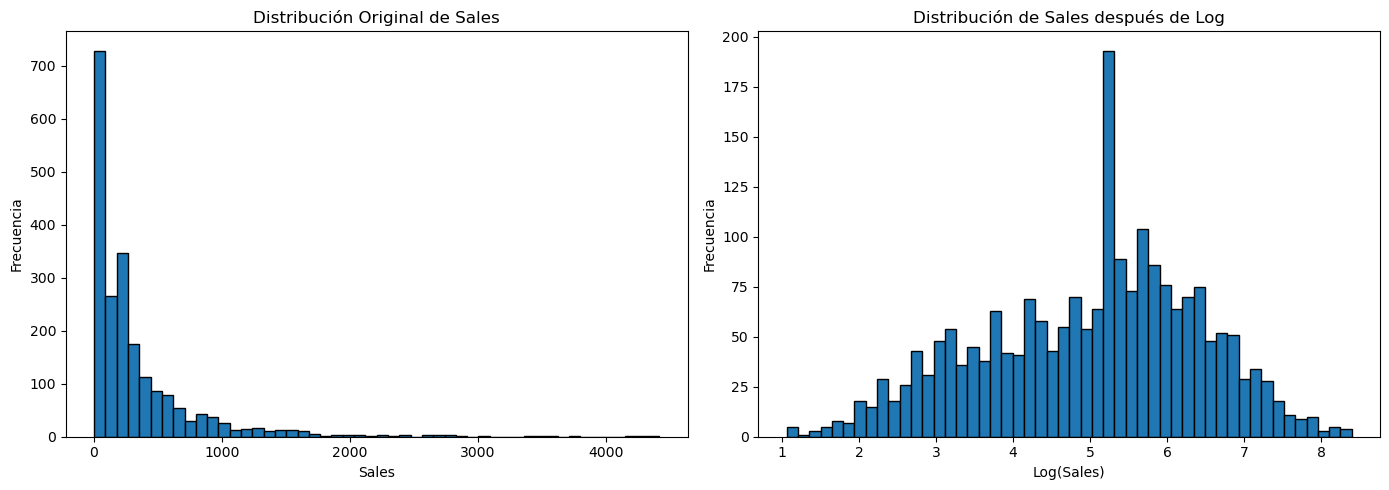

In [48]:
# TRANSFORMACIÓN DE VARIABLES NUMÉRICAS

# Criterio: Aplicar log a Sales para reducir asimetría
print("\n=== Transformación de Variables Numéricas ===")

# Verificar asimetría de Sales
skewness_original = skew(paso2_tranformacion_data_stores_sales['Sales'].dropna())
print(f"\nAsimetría de Sales original: {skewness_original:.4f}")

# Aplicar transformación logarítmica (log1p para manejar valores cercanos a 0)
paso2_tranformacion_data_stores_sales['Sales_Log'] = np.log1p(paso2_tranformacion_data_stores_sales['Sales'])

skewness_transformed = skew(paso2_tranformacion_data_stores_sales['Sales_Log'].dropna())
print(f"Asimetría de Sales después de log: {skewness_transformed:.4f}")

# Visualizar la diferencia
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(paso2_tranformacion_data_stores_sales['Sales'], bins=50, edgecolor='black')
axes[0].set_title('Distribución Original de Sales')
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frecuencia')

axes[1].hist(paso2_tranformacion_data_stores_sales['Sales_Log'], bins=50, edgecolor='black')
axes[1].set_title('Distribución de Sales después de Log')
axes[1].set_xlabel('Log(Sales)')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Los resultados son aceptables y totalmente coherentes porque:
- La asimetría original (3.47) refleja correctamente la naturaleza de datos de ventas
- La transformación logarítmica cumplió su objetivo: reducir drásticamente el sesgo
- El valor final (-0.30) está en el rango óptimo de simetría
- Los histogramas confirman visualmente la mejora

Esta transformacion ayudo a mejorar los datos para el modelo.

> ##### f. Escalado de características

In [53]:
# Crear copia de dataset para no afectar cambios en la version anterior
paso2_escalado_data_stores_sales = paso2_tranformacion_data_stores_sales.copy()

In [51]:
# ESCALADO DE CARACTERÍSTICAS

# Criterio: StandardScaler para normalizar variables numéricas
print("\n=== Escalado de Características ===")

from sklearn.preprocessing import StandardScaler

# Seleccionar variables numéricas para escalar
numeric_features = ['Sales', 'Quantity', 'Discount', 'Profit']

# Crear instancia del scaler
scaler = StandardScaler()

# Aplicar escalado
paso2_escalado_data_stores_sales[['Sales_Scaled', 'Quantity_Scaled', 'Discount_Scaled', 'Profit_Scaled']] = \
    scaler.fit_transform(paso2_escalado_data_stores_sales[numeric_features])

# Mostrar estadísticas antes y después
print("\nEstadísticas ANTES del escalado:")
print(paso2_escalado_data_stores_sales[numeric_features].describe())

print("\nEstadísticas DESPUÉS del escalado:")
print(paso2_escalado_data_stores_sales[['Sales_Scaled', 'Quantity_Scaled', 'Discount_Scaled', 'Profit_Scaled']].describe())

print(f"\nMedia de variables escaladas (cercana a 0):")
print(paso2_escalado_data_stores_sales[['Sales_Scaled', 'Quantity_Scaled', 'Discount_Scaled', 'Profit_Scaled']].mean())

print(f"\nDesviación estándar de variables escaladas (cercana a 1):")
print(paso2_escalado_data_stores_sales[['Sales_Scaled', 'Quantity_Scaled', 'Discount_Scaled', 'Profit_Scaled']].std())


=== Escalado de Características ===

Estadísticas ANTES del escalado:
             Sales     Quantity     Discount       Profit
count  2121.000000  2121.000000  2121.000000  2121.000000
mean    338.775569     3.741160     0.173923     8.699327
std     486.027946     2.197651     0.181547   136.049246
min       1.892000     1.000000     0.000000 -1862.312400
25%      51.968000     2.000000     0.000000   -12.849000
50%     182.670000     3.000000     0.200000     7.774800
75%     403.920000     5.000000     0.300000    33.726600
max    4416.174000    14.000000     0.700000  1013.127000

Estadísticas DESPUÉS del escalado:
       Sales_Scaled  Quantity_Scaled  Discount_Scaled  Profit_Scaled
count  2.121000e+03     2.121000e+03     2.121000e+03   2.121000e+03
mean  -2.345026e-17     8.710095e-17     6.532571e-17   8.375091e-18
std    1.000236e+00     1.000236e+00     1.000236e+00   1.000236e+00
min   -6.932997e-01    -1.247608e+00    -9.582280e-01  -1.375570e+01
25%   -5.902443e-01    -7.

In [54]:
# ESCALADO DE CARACTERÍSTICAS - StandardScaler

# Criterio: Normaliza datos a media 0 y desviación estándar 1
# Mejor para: Datos con distribución aproximadamente normal
# Sensible a: Outliers

print("\n=== StandardScaler ===")

# Seleccionar variables numéricas para escalar
numeric_features = ['Sales', 'Quantity', 'Discount', 'Profit']

# Aplicar StandardScaler
scaler_standard = StandardScaler()
paso2_escalado_data_stores_sales[['Sales_Standard', 'Quantity_Standard', 'Discount_Standard', 'Profit_Standard']] = \
    scaler_standard.fit_transform(paso2_escalado_data_stores_sales[numeric_features])

# Verificar estadísticas
standard_features = ['Sales_Standard', 'Quantity_Standard', 'Discount_Standard', 'Profit_Standard']
print("\nEstadísticas StandardScaler:")
print(paso2_escalado_data_stores_sales[standard_features].describe().round(3))


=== StandardScaler ===

Estadísticas StandardScaler:
       Sales_Standard  Quantity_Standard  Discount_Standard  Profit_Standard
count        2121.000           2121.000           2121.000         2121.000
mean           -0.000              0.000              0.000            0.000
std             1.000              1.000              1.000            1.000
min            -0.693             -1.248             -0.958          -13.756
25%            -0.590             -0.792             -0.958           -0.158
50%            -0.321             -0.337              0.144           -0.007
75%             0.134              0.573              0.695            0.184
max             8.391              4.669              2.898            7.385


In [55]:
# ESCALADO DE CARACTERÍSTICAS - MinMaxScaler

# Criterio: Escala datos al rango [0, 1]
# Mejor para: Cuando necesitas valores acotados entre 0 y 1
# Sensible a: Outliers (pueden comprimir la mayoría de datos)

print("\n=== MinMaxScaler ===")

# Aplicar MinMaxScaler
scaler_minmax = MinMaxScaler()
paso2_escalado_data_stores_sales[['Sales_MinMax', 'Quantity_MinMax', 'Discount_MinMax', 'Profit_MinMax']] = \
    scaler_minmax.fit_transform(paso2_escalado_data_stores_sales[numeric_features])

# Verificar estadísticas
minmax_features = ['Sales_MinMax', 'Quantity_MinMax', 'Discount_MinMax', 'Profit_MinMax']
print("\nEstadísticas MinMaxScaler:")
print(paso2_escalado_data_stores_sales[minmax_features].describe().round(3))


=== MinMaxScaler ===

Estadísticas MinMaxScaler:
       Sales_MinMax  Quantity_MinMax  Discount_MinMax  Profit_MinMax
count      2121.000         2121.000         2121.000       2121.000
mean          0.076            0.211            0.248          0.651
std           0.110            0.169            0.259          0.047
min           0.000            0.000            0.000          0.000
25%           0.011            0.077            0.000          0.643
50%           0.041            0.154            0.286          0.650
75%           0.091            0.308            0.429          0.659
max           1.000            1.000            1.000          1.000


In [56]:
# ESCALADO DE CARACTERÍSTICAS - RobustScaler

# Criterio: Usa mediana y rango intercuartil (IQR)
# Mejor para: Datos con outliers (más robusto que StandardScaler)
# Ventaja: No se ve afectado por valores extremos

print("\n=== 14.3 Escalado: RobustScaler ===")

from sklearn.preprocessing import RobustScaler

# Aplicar RobustScaler
scaler_robust = RobustScaler()
paso2_escalado_data_stores_sales[['Sales_Robust', 'Quantity_Robust', 'Discount_Robust', 'Profit_Robust']] = \
    scaler_robust.fit_transform(paso2_escalado_data_stores_sales[numeric_features])

# Verificar estadísticas
robust_features = ['Sales_Robust', 'Quantity_Robust', 'Discount_Robust', 'Profit_Robust']
print("\nEstadísticas RobustScaler:")
print(paso2_escalado_data_stores_sales[robust_features].describe().round(3))


=== 14.3 Escalado: RobustScaler ===

Estadísticas RobustScaler:
       Sales_Robust  Quantity_Robust  Discount_Robust  Profit_Robust
count      2121.000         2121.000         2121.000       2121.000
mean          0.444            0.247           -0.087          0.020
std           1.381            0.733            0.605          2.921
min          -0.514           -0.667           -0.667        -40.152
25%          -0.371           -0.333           -0.667         -0.443
50%           0.000            0.000            0.000          0.000
75%           0.629            0.667            0.333          0.557
max          12.029            3.667            1.667         21.585


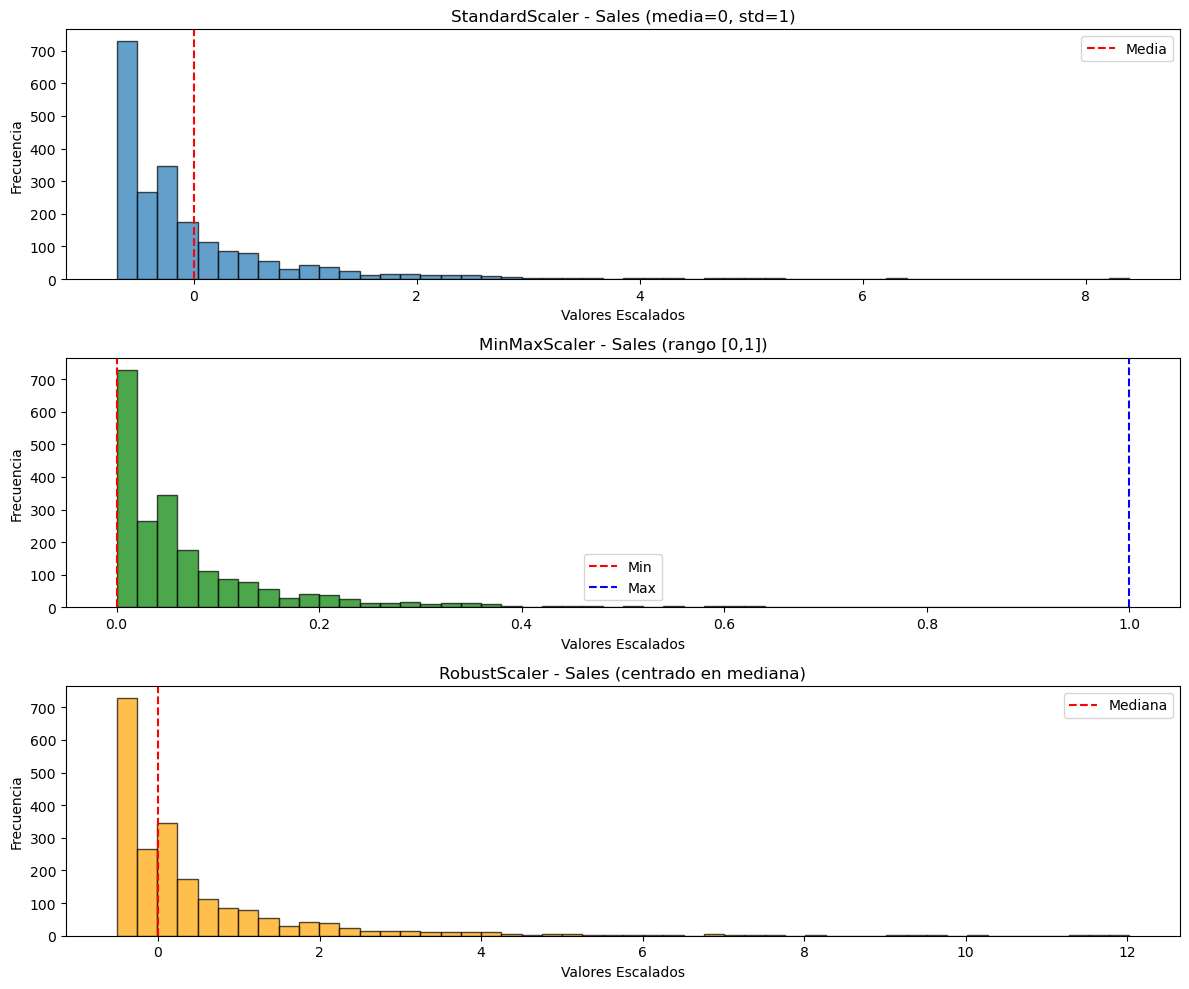

In [57]:
# COMPARACIÓN VISUAL DE LOS TRES ESCALADORES

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# StandardScaler
axes[0].hist(paso2_escalado_data_stores_sales['Sales_Standard'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('StandardScaler - Sales (media=0, std=1)')
axes[0].set_xlabel('Valores Escalados')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(0, color='red', linestyle='--', label='Media')
axes[0].legend()

# MinMaxScaler
axes[1].hist(paso2_escalado_data_stores_sales['Sales_MinMax'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('MinMaxScaler - Sales (rango [0,1])')
axes[1].set_xlabel('Valores Escalados')
axes[1].set_ylabel('Frecuencia')
axes[1].axvline(0, color='red', linestyle='--', label='Min')
axes[1].axvline(1, color='blue', linestyle='--', label='Max')
axes[1].legend()

# RobustScaler
axes[2].hist(paso2_escalado_data_stores_sales['Sales_Robust'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_title('RobustScaler - Sales (centrado en mediana)')
axes[2].set_xlabel('Valores Escalados')
axes[2].set_ylabel('Frecuencia')
axes[2].axvline(0, color='red', linestyle='--', label='Mediana')
axes[2].legend()

plt.tight_layout()
plt.show()

### 3. Documentación de decisiones y transformaciones

> ##### Documentar el orden de las transformaciones

Sales

1.	Imputación con mediana (si tiene nulos)
2.	Winsorización (límites basados en IQR)
3.	Transformación logarítmica (log1p)
4.	Escalado (Standard, MinMax, Robust)

Quantity

5.	Imputación con mediana (si tiene nulos)
6.	Escalado (Standard, MinMax, Robust)

Discount y Profit

7.	Escalado (Standard, MinMax, Robust)

Ship Mode

8.	Limpieza de nombres (espacios → guiones bajos)
9.	Imputación con moda (si tiene nulos)
10.	One-Hot Encoding (4 columnas: First_Class, Same_Day, Second_Class, Standard_Class)

Segment

11.	Limpieza de nombres (espacios → guiones bajos)
12.	Imputación con moda (si tiene nulos)
13.	One-Hot Encoding (3 columnas: Consumer, Corporate, Home_Office)

Region

14.	Label Encoding (Central=1, East=2, South=3, West=4)


> Inventario de Nuevas Features Generadas

Codificación One-Hot (Ship Mode)
- ShipMode_First_Class
- ShipMode_Same_Day
- ShipMode_Second_Class
- ShipMode_Standard_Class

Codificación One-Hot (Segment)
-	Segment_Consumer
-	Segment_Corporate
-	Segment_Home_Office

Codificación Label (Region)
- Region_Encoded

Tratamiento de Outliers
- Sales_Winsorized

Transformación Numérica
- Sales_Log

Escalado StandardScaler
- Sales_Standard
- Quantity_Standard
- Discount_Standard
- Profit_Standard

Escalado MinMaxScaler
- Sales_MinMax
- Quantity_MinMax
- Discount_MinMax
- Profit_MinMax

Escalado RobustScaler
- Sales_Robust
- Quantity_Robust
- Discount_Robust
- Profit_Robust


> ##### Justificar decisión con criterios durante el procesamiento

Durante el proceso de analisis del dataset no se encontraron valores nulos o vacios, por tal razon se aplico un codigo para agregar este tipo de datos y poder aplicar la validacion de outliers, si se utiliza otro dataset, es posible omitir este paso. Los criterios de selección de las variables se basan por el valor que podrian aportar cada una, siendo la variable objetivo principal de forecasting la columna sales, es la variable que se busca predecir. Quantity es una variable numerica que puede ayudar al modelo a entender el volumen. Discount puede tener relacion no lineal con Sales y Profit puede aportar información sobre rentabilidad de transacciones.

Por otro lado, durante la fase de transformación, la aplicacion de Winsorización consistio en limitar los valores extremos a un umbral definido, en lugar de eliminarlos. Con eliminación se pierden los registros completamente, mientras que con winsorización se sustituyen los valores por un límite superior permitido.

¿Por qué usar Winsorización en lugar de tecnicas como eliminacion, transformacion o imputacion?

No pierdes datos: En forecasting, cada registro tiene información temporal valiosa
Es una práctica estándar en forecasting para este tipo de situaciones
Reduce el impacto de outliers extremos en el modelo
Mantienes el tamaño del dataset: Importante para series temporales
Conserva información de eventos especiales

Todos los valores nulos han sido imputados, outliers tratados, variables transformadas y codificadas. El dataset está listo para la construcción del pipeline 